# Problem Statement:
Nowadays, traffic is a major issue for everyone, and it is a source of stress for anyone
who has to deal with it on a daily basis. The growth of the population delays traffic and
makes it worse day by day. The settlement of modern civilization looks at it, but it is
unable to act in such a way as to protect people. We can watch traffic, collect data, and
anticipate the next and subsequent observations using a variety of approaches and
patterns. The observation agency then makes observations, which are then required out
and predictions are made. Being stuck in a cosmopolitan city's traffic is the most
common occurrence in one's life.
The goal of this project is to build a prediction model using multiple machine learning
techniques and to use a template to document the end-to-end stages. We're trying to
forecast the value of a continuous variable with the Metro Interstate Traffic Volume
dataset, which is a regression issue.



# Attribute Information:

* holiday - Categorical US National holidays plus regional holiday, Minnesota State Fair
* temp Numeric Average temp in kelvin
* rain_1h - Numeric Amount in mm of rain that occurred in the hour
* snow_1h - Numeric Amount in mm of snow that occurred in the hour
* clouds_all - Numeric Percentage of cloud cover
* weather_main - Categorical Short textual description of the current weather
* weather_description - Categorical Longer textual description of the current weather
* date_time - DateTime Hour of the data collected in local CST time
* traffic_volume - Numeric Hourly I-94 ATR 301 reported westbound traffic volume

You can get the dataset from this link:
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

# Importing required libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pickle
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',10)
%matplotlib inline 

In [33]:
!pip install cassandra-driver

# Read dataset

In [82]:
# specifying client_id and client_secret to connect to cassandra database

client_id = "mlIYceFbdjDIIbJoMUAZqlSw"

client_secret = "24OAHYj3OFitt5I,P-rCo5yBgkwwwEDuZrE9FZ9ZEFfuozXIZCL,JH_O_2oRQZiceO19ATi_8-8143cYAR5cnW0AOQ,3ZIDhxSSfw_LKtCLL_SZbmagFYw_WPFMpi-os"

In [185]:
# connecting to cassandra database

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config= {
        'secure_connect_bundle': 'secure-connect-metro-traffic.zip'
}
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

df = pd.DataFrame(list(session.execute("SELECT * FROM traffic_volume.metro")))

In [186]:
df.head()

,date_time,clouds_all,holiday,rain_1h,snow_1h,temp,traffic_volume,weather_description,weather_main
0,2/5/2014 12:00,90,None,0,0,256.56,4678,overcast clouds,Clouds
1,4/25/2017 22:00,90,None,0,0,284.09,1688,drizzle,Drizzle
2,1/3/2017 14:00,40,None,0,0,261.59,4863,haze,Haze
3,4/9/2017 8:00,90,None,0,0,282.85,1938,overcast clouds,Clouds
4,7/30/2014 9:00,1,None,0.25,0,292.56,5519,light rain,Rain


In [187]:
df.shape

(40575, 9)

## Glimpse data

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date_time            40575 non-null  object
 1   clouds_all           40575 non-null  int64 
 2   holiday              40575 non-null  object
 3   rain_1h              40575 non-null  object
 4   snow_1h              40575 non-null  object
 5   temp                 40575 non-null  object
 6   traffic_volume       40575 non-null  int64 
 7   weather_description  40575 non-null  object
 8   weather_main         40575 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.8+ MB


In [189]:
df.describe()

,clouds_all,traffic_volume
count,40575.000000,40575.000000
mean,44.203253,3290.650474
std,38.686321,1984.772909
min,0.000000,0.000000
25%,1.000000,1248.500000
50%,40.000000,3427.000000
75%,90.000000,4952.000000
max,100.000000,7280.000000


In [190]:
df.describe(include='object')

,date_time,holiday,rain_1h,snow_1h,temp,weather_description,weather_main
count,40575,40575,40575,40575,40575,40575,40575
unique,40575,12,372,12,5841,35,11
top,10/29/2012 13:00,None,0,0,274.15,sky is clear,Clouds
freq,1,40522,38521,40544,80,11645,15120


# Checking missing, duplicate values and datatypes

In [191]:
df.isnull().sum()

date_time              0
clouds_all             0
holiday                0
rain_1h                0
snow_1h                0
temp                   0
traffic_volume         0
weather_description    0
weather_main           0
dtype: int64

#### There is no missing value at all

In [192]:
df.duplicated().sum()

0

#### 17 rows are duplicated, we should remove them.

In [193]:
df.drop_duplicates(inplace=True)

### Let's check datatypes of each column

In [194]:
df.dtypes

date_time              object
clouds_all              int64
holiday                object
rain_1h                object
snow_1h                object
temp                   object
traffic_volume          int64
weather_description    object
weather_main           object
dtype: object

"date_time" column should be with **datetime** datatype!

In [195]:
df['date_time']=pd.to_datetime(df['date_time'])

In [196]:
df['rain_1h']=df['rain_1h'].astype('float64')

In [197]:
df['snow_1h']=df['snow_1h'].astype('float64')

In [198]:
df['temp']=df['temp'].astype('float64')

In [199]:
df.dtypes

date_time              datetime64[ns]
clouds_all                      int64
holiday                        object
rain_1h                       float64
snow_1h                       float64
temp                          float64
traffic_volume                  int64
weather_description            object
weather_main                   object
dtype: object

It seems all datatypes are correct now!

In [200]:
df.shape

(40575, 9)

In [201]:
df['date_time'].min(),df['date_time'].max()

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

Timeframe in the dataset is between 2012-10-02 09:00 and 2018-09-30 23:00.

# Exploratory Data Analysis

In [202]:
df.sort_values(by=['date_time'],inplace=True)

<AxesSubplot:title={'center':'Special day counts'}, xlabel='count', ylabel='holiday'>

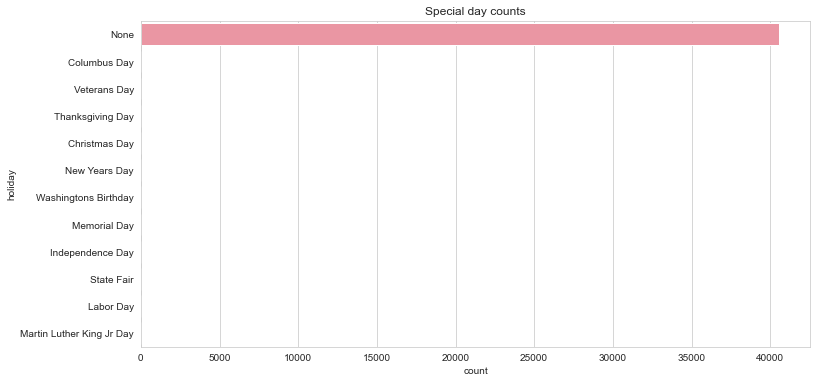

In [101]:
plt.figure(figsize=(12,6))
plt.title('Special day counts')
sns.countplot(y='holiday',data=df)

It is difficult to see counts of special days as there are far more non holiday days. Let's exclude "None" to see the number of all special days clearly in the dataset.

<AxesSubplot:title={'center':'Special day counts'}, xlabel='count', ylabel='holiday'>

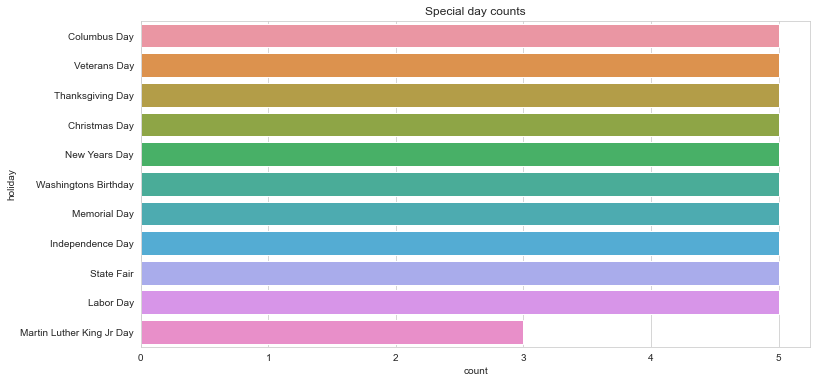

In [102]:
plt.figure(figsize=(12,6))
plt.title('Special day counts')
sns.countplot(y='holiday',data=df[df['holiday']!='None'])

Let's analyze the frequency of weather condition (weather_main)! 

<AxesSubplot:xlabel='count', ylabel='weather_main'>

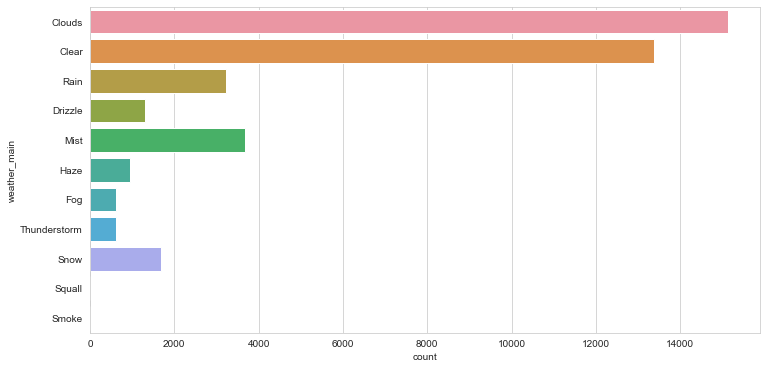

In [103]:
plt.figure(figsize=(12,6))
sns.countplot(y='weather_main',data=df)

In [104]:
df['weather_main'].value_counts()

Clouds          15120
Clear           13369
Mist             3677
Rain             3233
Snow             1683
Drizzle          1298
Haze              949
Thunderstorm      624
Fog               615
Squall              4
Smoke               3
Name: weather_main, dtype: int64

There are 11 weather_main unique values. It is okay to keep all of them in the dataset.

<AxesSubplot:xlabel='count', ylabel='weather_description'>

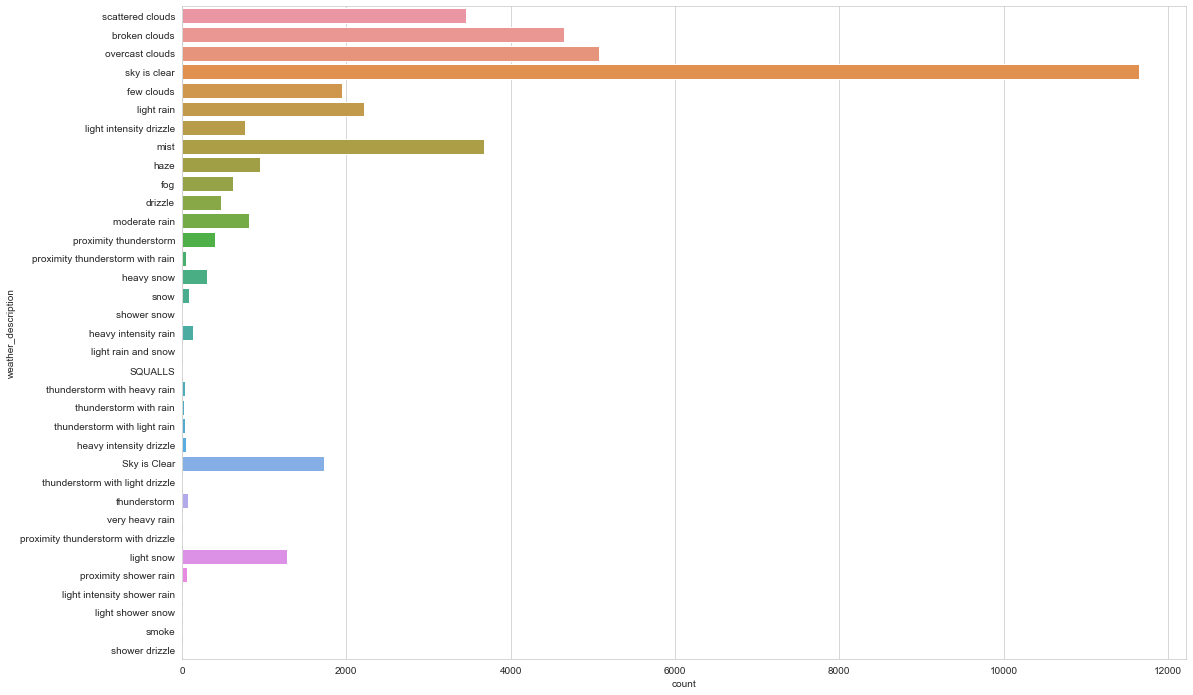

In [105]:
# plotting the frequency of weather_description values
plt.figure(figsize=(18,12))
sns.countplot(y='weather_description',data=df)

Indeed, "weather_description" carries approximately the same information with "weather_main" feature.
Thus, we will remove "weather_description" column.

In our dataset, temperature values in "temp" column is given in Kelvin. For simplicity, i will convert it to Celcius.

In [203]:
df['temp']=df['temp']-273

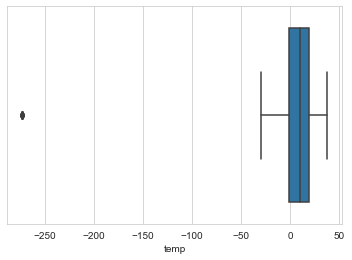

In [204]:
sns.boxplot(df['temp'])
plt.show()

As shown in boxplot above, there is an anomaly. Temperature less than -250 Celcius is not possible. Let's remove an outlier.

In [205]:
# define function to remove outliers
def remove_outlier(df,x):
    Q3,Q1 = np.percentile(df,[75,25])
    IQR = Q3 - Q1
    # Upper bound
    upper = np.where(df >= (Q3+1.5*IQR))
    # Lower bound
    lower = np.where(df <= (Q1-1.5*IQR))
 
    #Removing the Outliers
    x.drop(upper[0], inplace = True)
    x.drop(lower[0], inplace = True)
    
remove_outlier(df['temp'],df)

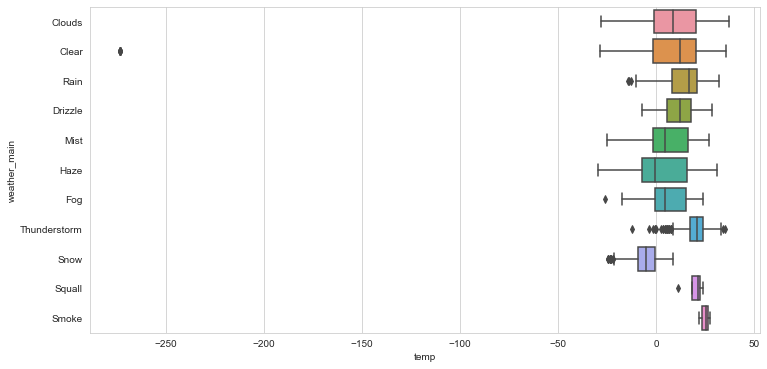

In [206]:
plt.figure(figsize=(12,6))
sns.boxplot(x='temp', y = 'weather_main', data = df)
plt.show()

### Distribution of numerical values

<AxesSubplot:xlabel='rain_1h', ylabel='Density'>

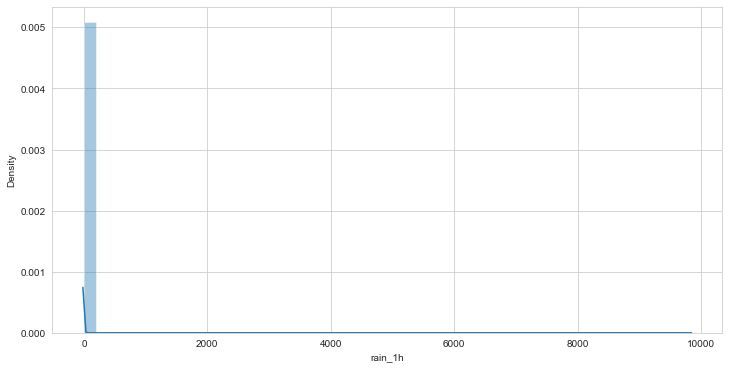

In [207]:
plt.figure(figsize=(12,6))
sns.distplot(df['rain_1h'])

<AxesSubplot:xlabel='snow_1h', ylabel='Density'>

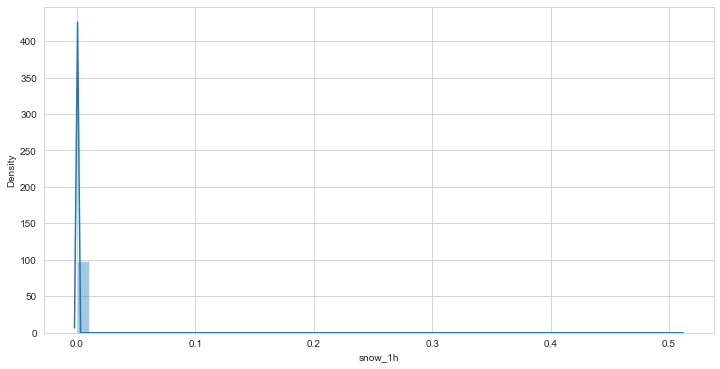

In [208]:
plt.figure(figsize=(12,6))
sns.distplot(df['snow_1h'])

Both of them are highly skewed. Most of values are close to 0.

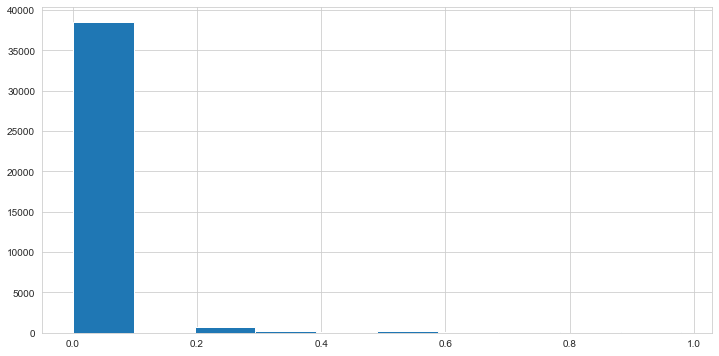

In [209]:
plt.figure(figsize=(12,6))
plt.hist(df.rain_1h.loc[df.rain_1h<1])
plt.show()

In [210]:
df['clouds_all'].min(),df['clouds_all'].max()

(0, 100)

<AxesSubplot:xlabel='clouds_all', ylabel='Density'>

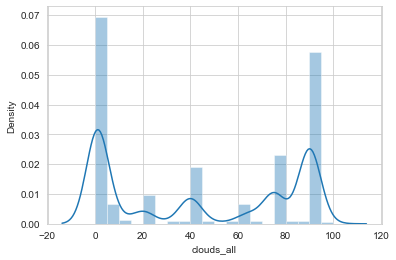

In [211]:
sns.distplot(df['clouds_all'],kde=True)

<AxesSubplot:xlabel='temp', ylabel='Density'>

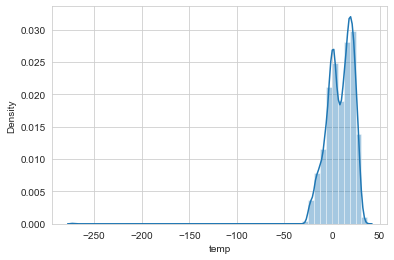

In [212]:
sns.distplot(df['temp'],kde=True)

In [213]:
cols = ['clouds_all','rain_1h','snow_1h','temp']
for i in cols:
    print("Skewness of " + i, df[i].skew())

Skewness of clouds_all 0.0295156865497017
Skewness of rain_1h 201.33256641294804
Skewness of snow_1h 65.89851116743372
Skewness of temp -2.3922196226473296


* **clouds all** - the distribution is fairly symmetrical
* **temp** - the distribution is fairly symmetrical
* **rain_1h** - a highly skewed distribution.
* **snow_1h** - a highly skewed distribution.

# Bivariate analysis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Clouds'),
  Text(1, 0, 'Clear'),
  Text(2, 0, 'Rain'),
  Text(3, 0, 'Drizzle'),
  Text(4, 0, 'Mist'),
  Text(5, 0, 'Haze'),
  Text(6, 0, 'Fog'),
  Text(7, 0, 'Thunderstorm'),
  Text(8, 0, 'Snow'),
  Text(9, 0, 'Squall'),
  Text(10, 0, 'Smoke')])

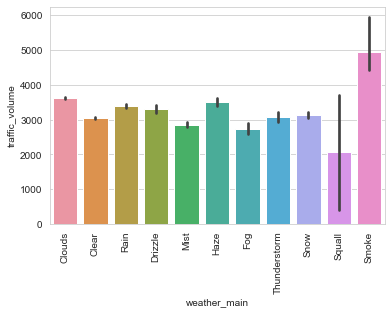

In [214]:
sns.barplot(data = df, x = 'weather_main', y = 'traffic_volume' )
plt.xticks(rotation = 90)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

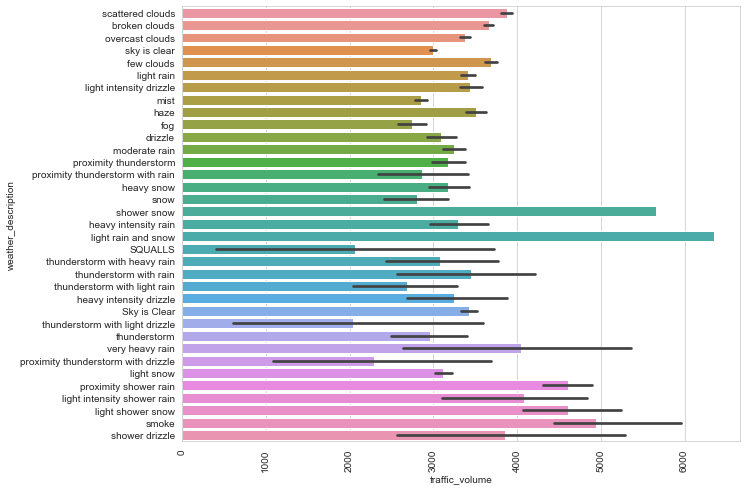

In [215]:
plt.figure(figsize = (10,8))
sns.barplot(data = df, y = 'weather_description', x = 'traffic_volume' )
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'None'),
  Text(1, 0, 'Columbus Day'),
  Text(2, 0, 'Veterans Day'),
  Text(3, 0, 'Thanksgiving Day'),
  Text(4, 0, 'Christmas Day'),
  Text(5, 0, 'New Years Day'),
  Text(6, 0, 'Washingtons Birthday'),
  Text(7, 0, 'Memorial Day'),
  Text(8, 0, 'Independence Day'),
  Text(9, 0, 'State Fair'),
  Text(10, 0, 'Labor Day'),
  Text(11, 0, 'Martin Luther King Jr Day')])

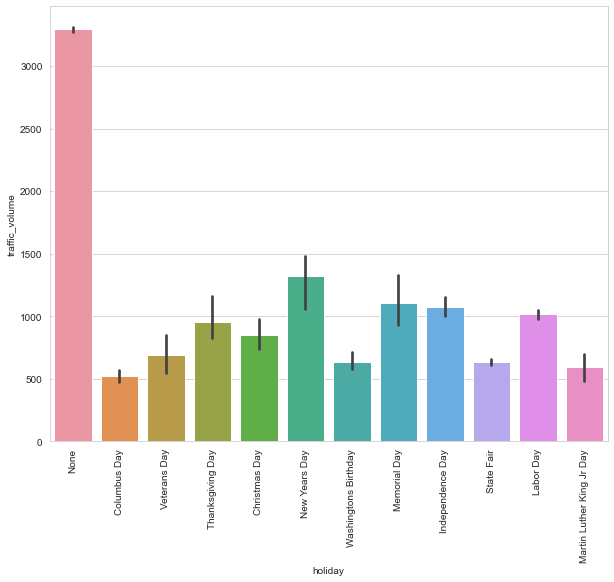

In [216]:
plt.figure(figsize = (10,8))
sns.barplot(x = 'holiday', y = 'traffic_volume', data = df)
plt.xticks(rotation = 90)

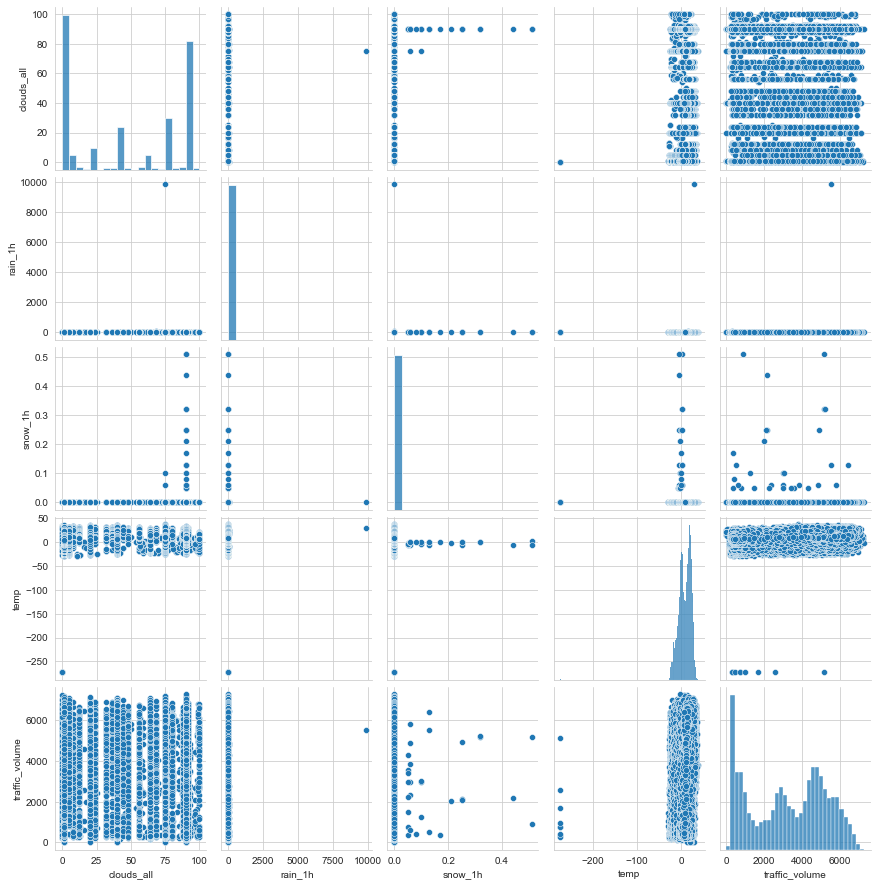

In [217]:
sns.pairplot(df)

# Feature Engineering

In [293]:
data = df.copy()
# create new columns from date_time
data['weekday'] = data.date_time.dt.weekday
data['hour'] = data.date_time.dt.hour
data['month'] = data.date_time.dt.month
data['year'] = data.date_time.dt.year
#Monday is 0 and Sunday is 6

In [294]:
data.head()

,date_time,clouds_all,holiday,rain_1h,snow_1h,...,weather_main,weekday,hour,month,year
23639,2012-10-02 09:00:00,40,None,0.0,0.0,...,Clouds,1,9,10,2012
8582,2012-10-02 10:00:00,75,None,0.0,0.0,...,Clouds,1,10,10,2012
30262,2012-10-02 11:00:00,90,None,0.0,0.0,...,Clouds,1,11,10,2012
30035,2012-10-02 12:00:00,90,None,0.0,0.0,...,Clouds,1,12,10,2012
12048,2012-10-02 13:00:00,75,None,0.0,0.0,...,Clouds,1,13,10,2012


<AxesSubplot:xlabel='weekday', ylabel='traffic_volume'>

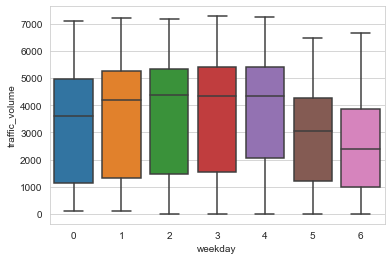

In [295]:
sns.boxplot(x = 'weekday', y = 'traffic_volume', data = data)

In [296]:
def hour_modify(x):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [24,1,2,3]
    if x in Early_Morning:
        return 'Early Morning'
    elif x in Morning:
        return 'Morning'
    elif x in Afternoon:
        return 'Afternoon'
    elif x in Evening:
        return 'Evening'
    elif x in Night:
        return 'Night'
    else:
        return 'Late Night'
    
data['hour'] = data.hour.apply(hour_modify)

In [297]:
def modify_holiday(x):
    if x == 'None':
        return False
    else:
        return True
    
data['holiday'] = data['holiday'].apply(modify_holiday)

In [298]:
data

,date_time,clouds_all,holiday,rain_1h,snow_1h,...,weather_main,weekday,hour,month,year
23639,2012-10-02 09:00:00,40,False,0.0,0.0,...,Clouds,1,Morning,10,2012
8582,2012-10-02 10:00:00,75,False,0.0,0.0,...,Clouds,1,Morning,10,2012
30262,2012-10-02 11:00:00,90,False,0.0,0.0,...,Clouds,1,Morning,10,2012
30035,2012-10-02 12:00:00,90,False,0.0,0.0,...,Clouds,1,Afternoon,10,2012
12048,2012-10-02 13:00:00,75,False,0.0,0.0,...,Clouds,1,Afternoon,10,2012
...,...,...,...,...,...,...,...,...,...,...,...
35907,2018-09-30 19:00:00,75,False,0.0,0.0,...,Clouds,6,Evening,9,2018
22523,2018-09-30 20:00:00,90,False,0.0,0.0,...,Clouds,6,Night,9,2018
26841,2018-09-30 21:00:00,90,False,0.0,0.0,...,Thunderstorm,6,Night,9,2018
35918,2018-09-30 22:00:00,90,False,0.0,0.0,...,Clouds,6,Night,9,2018


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Morning'),
  Text(1, 0, 'Afternoon'),
  Text(2, 0, 'Evening'),
  Text(3, 0, 'Night'),
  Text(4, 0, 'Late Night'),
  Text(5, 0, 'Early Morning')])

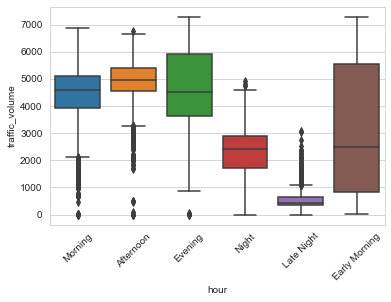

In [299]:
sns.boxplot(x = 'hour', y = 'traffic_volume', data = data)
plt.xticks(rotation = 45)

**At night** and **late night** there is less traffic.

In [300]:
data[['month','weekday']] = data[['month','weekday']] .astype('category')

In [301]:
data.dtypes

date_time              datetime64[ns]
clouds_all                      int64
holiday                          bool
rain_1h                       float64
snow_1h                       float64
temp                          float64
traffic_volume                  int64
weather_description            object
weather_main                   object
weekday                      category
hour                           object
month                        category
year                            int64
dtype: object

In [306]:
# remove 'weather_description', 'year' column
data.drop(['weather_description','year'], axis=1, inplace=True)

In [307]:
data.head()

,date_time,clouds_all,holiday,rain_1h,snow_1h,...,traffic_volume,weather_main,weekday,hour,month
23639,2012-10-02 09:00:00,40,False,0.0,0.0,...,5545,Clouds,1,Morning,10
8582,2012-10-02 10:00:00,75,False,0.0,0.0,...,4516,Clouds,1,Morning,10
30262,2012-10-02 11:00:00,90,False,0.0,0.0,...,4767,Clouds,1,Morning,10
30035,2012-10-02 12:00:00,90,False,0.0,0.0,...,5026,Clouds,1,Afternoon,10
12048,2012-10-02 13:00:00,75,False,0.0,0.0,...,4918,Clouds,1,Afternoon,10


We will remove 'snow_1h' and 'rain_1h' features as most of their values are 0.

In [308]:
data.drop(['snow_1h','rain_1h'],inplace=True,axis=1)

In [309]:
data['traffic_volume'].skew()

-0.10732744532227065

**'traffic_volume'** has a skewness value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [310]:
data.set_index('date_time',inplace=True)

In [311]:
data.head()

,clouds_all,holiday,temp,traffic_volume,weather_main,weekday,hour,month
date_time,,,,,,,,
2012-10-02 09:00:00,40,False,15.28,5545,Clouds,1,Morning,10
2012-10-02 10:00:00,75,False,16.36,4516,Clouds,1,Morning,10
2012-10-02 11:00:00,90,False,16.58,4767,Clouds,1,Morning,10
2012-10-02 12:00:00,90,False,17.13,5026,Clouds,1,Afternoon,10
2012-10-02 13:00:00,75,False,18.14,4918,Clouds,1,Afternoon,10


In [312]:
# Define dependent and independent variables
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']

In [313]:
X

,clouds_all,holiday,temp,weather_main,weekday,hour,month
date_time,,,,,,,
2012-10-02 09:00:00,40,False,15.28,Clouds,1,Morning,10
2012-10-02 10:00:00,75,False,16.36,Clouds,1,Morning,10
2012-10-02 11:00:00,90,False,16.58,Clouds,1,Morning,10
2012-10-02 12:00:00,90,False,17.13,Clouds,1,Afternoon,10
2012-10-02 13:00:00,75,False,18.14,Clouds,1,Afternoon,10
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,75,False,10.45,Clouds,6,Evening,9
2018-09-30 20:00:00,90,False,9.76,Clouds,6,Night,9
2018-09-30 21:00:00,90,False,9.73,Thunderstorm,6,Night,9


In [314]:
X['hour'].unique()

array(['Morning', 'Afternoon', 'Evening', 'Night', 'Late Night',
       'Early Morning'], dtype=object)

# Train test splitting

In [315]:
# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=101)

# Implementation of different models

In [316]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_vars = ['temp','clouds_all']
cat_vars = ['holiday','weather_main', 'weekday', 'hour', 'month']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('encoder',OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])


In [317]:
models = [AdaBoostRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), 
         CatBoostRegressor(), XGBRegressor()]

model_labels = ['AdaBoost','GradientBoost','RandomForest','CatBoost','XGBoost']
r2_scores = []

for model in models:
    data_pipeline = Pipeline(steps = [
                                    ('preprocessor', preprocessor),
                                    ('model', model)])
    
    r2_score = cross_val_score(data_pipeline, X_train, y_train, cv=KFold(n_splits=10), scoring='r2',n_jobs=-1).mean()
    r2_scores.append(r2_score)


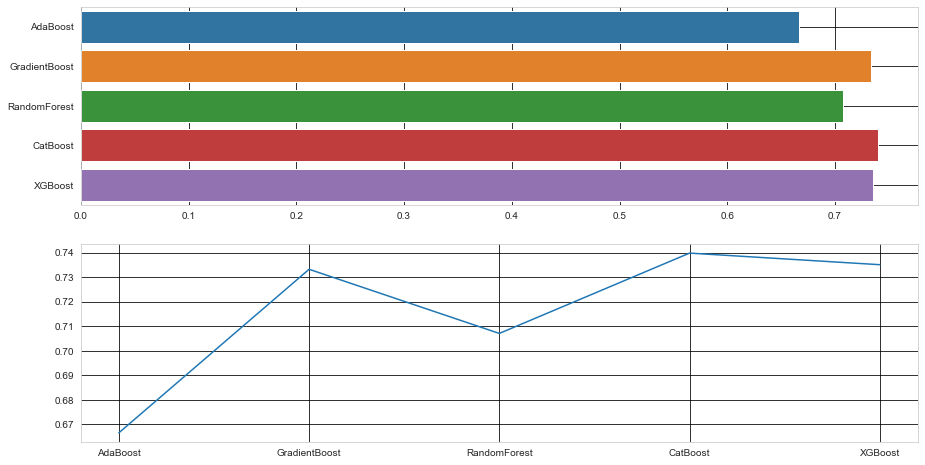

In [318]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15,8))

sns.set_style('dark')
sns.barplot(y = model_labels ,x = r2_scores, ax=axes[0])
axes[0].grid(True, color='k')

sns.set_style('whitegrid')
sns.lineplot(x = model_labels, y = r2_scores)
axes[1].grid(True, color='k')
fig.show()


In [319]:
results = zip(model_labels,r2_scores)
print(list(results))

[('AdaBoost', 0.6666115938673178), ('GradientBoost', 0.733184067997394), ('RandomForest', 0.7070672964875474), ('CatBoost', 0.7397649887765038), ('XGBoost', 0.7350495297411997)]


**CatBoostRegressor** has high R2 score! Let's optimize our model with GridSearch and Cross Validation.

# Optimization by using GridSearch and Cross Validation

In [241]:
data_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                  ('model', CatBoostRegressor(random_state=42))])

In [195]:
rf_grid= {'model__depth':[6,8],
    'model__learning_rate':[0.1,0.5,0.3],
    'model__iterations':[100],
          'model__min_data_in_leaf':[500,700]
}

grid_search = GridSearchCV(data_pipeline,param_grid=rf_grid,n_jobs=-1,cv=KFold(n_splits=3))

grid_search.fit(X_train,y_train)

0:	learn: 1848.7401394	total: 21.4ms	remaining: 2.12s
1:	learn: 1726.0165850	total: 26.9ms	remaining: 1.32s
2:	learn: 1630.6304572	total: 32.3ms	remaining: 1.04s
3:	learn: 1537.4312501	total: 38ms	remaining: 912ms
4:	learn: 1457.5586245	total: 43.4ms	remaining: 826ms
5:	learn: 1389.4837476	total: 49.2ms	remaining: 771ms
6:	learn: 1331.7808660	total: 54.5ms	remaining: 724ms
7:	learn: 1283.1290528	total: 59.8ms	remaining: 688ms
8:	learn: 1242.3154031	total: 65.2ms	remaining: 660ms
9:	learn: 1213.5564344	total: 70.7ms	remaining: 637ms
10:	learn: 1184.0960986	total: 76.3ms	remaining: 617ms
11:	learn: 1159.6787977	total: 82.1ms	remaining: 602ms
12:	learn: 1139.5124114	total: 87.4ms	remaining: 585ms
13:	learn: 1124.1750455	total: 92.9ms	remaining: 571ms
14:	learn: 1111.4739909	total: 98.6ms	remaining: 559ms
15:	learn: 1099.0439183	total: 104ms	remaining: 547ms
16:	learn: 1089.8048590	total: 110ms	remaining: 536ms
17:	learn: 1082.7157276	total: 116ms	remaining: 527ms
18:	learn: 1076.8272464	t

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'clouds_all']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['holiday',
                                   

#### This will try out 4 * 3 * 3 * 3 * 2 * 1 = 216 combinations of settings. We can display the best parameters, and evaluate performance:

In [196]:
grid_search.best_params_

{'model__depth': 6,
 'model__iterations': 100,
 'model__learning_rate': 0.1,
 'model__min_data_in_leaf': 500}

In [320]:
pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                  ('model', CatBoostRegressor(iterations=100,
                                                              depth=8,
                                                              learning_rate=0.1,
                                                             loss_function='RMSE',
                                                             random_seed=29,
                                                             bagging_temperature=0.95,
                                                             min_data_in_leaf=500))])
r2_scores = cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=5), scoring='r2',n_jobs=-1)
print('max r2 :', r2_scores.max())
print('min r2 :', r2_scores.min())
print('mean r2 :', r2_scores.mean())

max r2 : 0.7517410407422752
min r2 : 0.7284821975604526
mean r2 : 0.7399645786077771


# Model Testing

In [321]:
pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)

0:	learn: 1848.8805675	total: 23.3ms	remaining: 2.3s
1:	learn: 1726.1861782	total: 31.3ms	remaining: 1.53s
2:	learn: 1619.7945438	total: 39.7ms	remaining: 1.28s
3:	learn: 1528.2382342	total: 46.4ms	remaining: 1.11s
4:	learn: 1448.4690265	total: 55.1ms	remaining: 1.05s
5:	learn: 1380.3918871	total: 62.9ms	remaining: 985ms
6:	learn: 1323.0776364	total: 70.2ms	remaining: 932ms
7:	learn: 1274.2679434	total: 78ms	remaining: 897ms
8:	learn: 1232.5136505	total: 86.1ms	remaining: 871ms
9:	learn: 1198.2019305	total: 94.2ms	remaining: 848ms
10:	learn: 1169.6960586	total: 103ms	remaining: 830ms
11:	learn: 1146.1545980	total: 112ms	remaining: 820ms
12:	learn: 1126.8579000	total: 120ms	remaining: 803ms
13:	learn: 1109.5387060	total: 128ms	remaining: 786ms
14:	learn: 1095.3025617	total: 136ms	remaining: 772ms
15:	learn: 1084.9984109	total: 144ms	remaining: 758ms
16:	learn: 1074.7128497	total: 152ms	remaining: 743ms
17:	learn: 1066.3299330	total: 160ms	remaining: 731ms
18:	learn: 1059.6982799	total: 

In [322]:
mean_absolute_error(y_test,y_pred)

703.2864121967356

In [323]:
np.sqrt(mean_absolute_error(y_test,y_pred))

26.51954773740939

In [324]:
y_pred

array([ 413.15790189,  976.39319153, 2086.3986123 , ..., 4283.82153478,
       4920.43478976,  339.26368101])

# Exporting model

In [326]:
document = "mypickle.pkl"
    
pickle.dump(pipeline,open(document,"wb"))